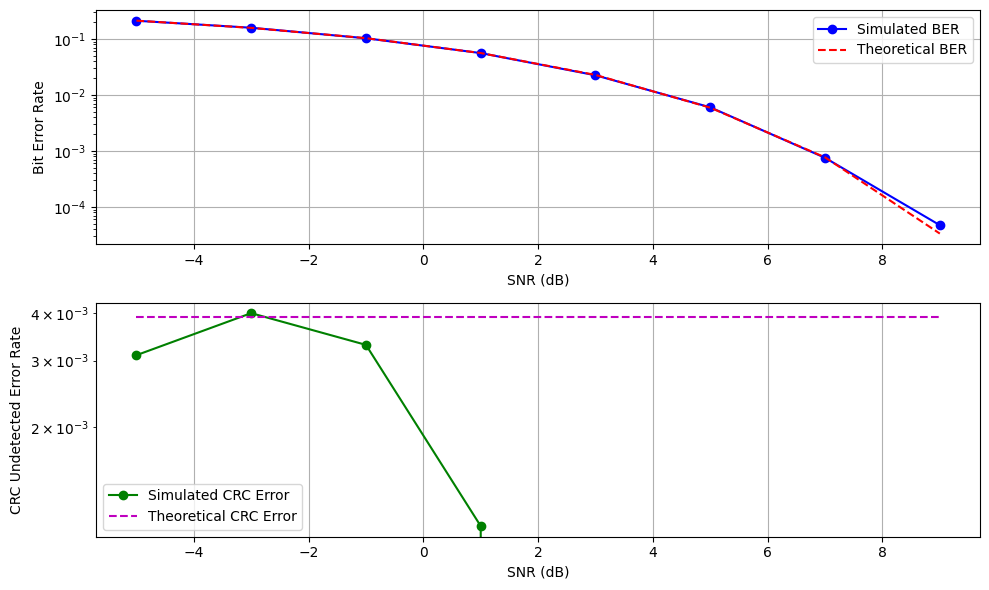

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Параметры системы
l = 32  # длина данных
r = 8   # длина CRC
crc_poly = [1, 0, 0, 0, 0, 0, 1, 1, 1]  # Пример полинома CRC-8 (0x07 в шестнадцатеричном формате)
N = 10000  # количество пакетов
SNR_dBs = np.arange(-5, 11, 2)  # значения SNR в дБ

def compute_crc(data_bits, poly):
    """
    Вычисление CRC для данных
    :param data_bits: список битов данных
    :param poly: порождающий полином (список битов)
    :return: биты CRC
    """
    poly = np.array(poly, dtype=int)
    data = np.array(data_bits, dtype=int)
    len_poly = len(poly)
    len_data = len(data)
    # Сдвигаем данные на (len_poly - 1) бит влево
    shifted_data = np.concatenate([data, np.zeros(len_poly - 1, dtype=int)])
    # Деление полинома
    for i in range(len_data):
        if shifted_data[i] == 1:
            shifted_data[i:i+len_poly] ^= poly
    # Возвращаем остаток
    crc = shifted_data[-len_poly + 1:]
    return crc.tolist()

def bpsk_modulate(bits):
    """
    Модуляция BPSK: 0 -> +1, 1 -> -1
    """
    return np.array([-1 if bit else 1 for bit in bits])

def add_awgn(signal, snr_db):
    """
    Добавление шума к сигналу
    :param signal: модулированный сигнал
    :param snr_db: SNR в дБ
    :return: сигнал с шумом
    """
    snr_linear = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * snr_linear))
    noise = np.random.normal(0, sigma, len(signal))
    return signal + noise

def bpsk_demodulate(received_signal):
    """
    Демодуляция BPSK: если принятый сигнал >= 0 -> 0, иначе 1
    """
    return [0 if s >= 0 else 1 for s in received_signal]

def check_crc(received_bits, poly):
    """
    Проверка CRC
    :return: синдром (0 - OK, не 0 - ошибка)
    """
    poly = np.array(poly, dtype=int)
    data = np.array(received_bits, dtype=int)
    len_poly = len(poly)
    for i in range(len(data) - len_poly + 1):
        if data[i] == 1:
            data[i:i+len_poly] ^= poly
    syndrome = data[-len_poly + 1:]
    return np.any(syndrome != 0)

# Моделирование
ber_estimates = []
crc_error_estimates = []
theoretical_ber = []
theoretical_crc_error = 1 / (2 ** r)  # Теоретическая вероятность необнаруженной ошибки CRC

for snr_db in SNR_dBs:
    total_bits = 0
    error_bits = 0
    crc_undetected = 0
    
    for _ in range(N):
        # Генерация данных
        m = np.random.randint(0, 2, l).tolist()
        # Вычисление CRC
        crc_bits = compute_crc(m, crc_poly)
        # Кодовое слово
        codeword = m + crc_bits
        # Модуляция
        modulated = bpsk_modulate(codeword)
        # Канал с шумом
        received = add_awgn(modulated, snr_db)
        # Демодуляция
        demod_bits = bpsk_demodulate(received)
        # Проверка CRC
        received_data = demod_bits[:l]
        received_crc = demod_bits[l:]
        # Пересчитываем CRC из полученных данных
        expected_crc = compute_crc(received_data, crc_poly)
        # Синдром
        syndrome = check_crc(demod_bits, crc_poly)
        # Подсчет ошибок
        # Ошибки бит
        bit_errors = sum(r != t for r, t in zip(codeword, demod_bits))
        error_bits += bit_errors
        total_bits += len(codeword)
        # Проверка на необнаруженную ошибку
        if not syndrome:
            if received_data != m:
                crc_undetected += 1
    
    # Оценки
    ber_estimates.append(error_bits / total_bits)
    crc_error_estimates.append(crc_undetected / N)
    # Теоретическая BER
    snr_linear = 10 ** (snr_db / 10)
    theoretical_ber.append(0.5 * erfc(np.sqrt(snr_linear)))

# Построение графиков
plt.figure(figsize=(10, 6))

# График BER
plt.subplot(2, 1, 1)
plt.semilogy(SNR_dBs, ber_estimates, 'bo-', label='Simulated BER')
plt.semilogy(SNR_dBs, theoretical_ber, 'r--', label='Theoretical BER')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.grid(True)
plt.legend()

# График ошибок CRC
plt.subplot(2, 1, 2)
plt.semilogy(SNR_dBs, crc_error_estimates, 'go-', label='Simulated CRC Error')
plt.semilogy(SNR_dBs, [theoretical_crc_error]*len(SNR_dBs), 'm--', label='Theoretical CRC Error')
plt.xlabel('SNR (dB)')
plt.ylabel('CRC Undetected Error Rate')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()